# <img style="float: left; padding-right: 10px; width: 45px" src="fig/iacs.png"> S-109A Introduction to Data Science 
## Homework 3 - Forecasting Bike Sharing Usage



**Harvard University**<br/>
**Summer 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

Erik Johnsson and Nathan Goldberg

<hr style="height:2pt">

In [1]:
from IPython.core.display import HTML
def css_styling(): styles = open("cs109.css", "r").read(); return HTML(styles)
css_styling()

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Subset Selection, Polynomial Regression </div>
### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. You will prepare a small report for them.

The hourly demand information would be useful in planning the number of bikes that need to be available in the system on any given hour of the day, and also in monitoring traffic in the city. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore techniques for subset selection. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on attributes about the hour and the day. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).


### Use only the libraries below:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns

%matplotlib inline

## Data Exploration & Preprocessing, Multiple Linear Regression, Subset Selection


### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will add some features that will help us with the analysis and then separate it into training and test sets. Each row in this file contains 12 attributes and each entry represents one hour of a 24-hour day with its weather, etc, and the number of rental rides for that day divided in categories according to if they were made by registered or casual riders. Those attributes are the following:

- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius)
- `hum` (relative humidity)
- `windspeed` (wind speed)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

### General Hints
- Use pandas .describe() to see statistics for the dataset.
- When performing manipulations on column data it is useful and often more efficient to write a function and apply this function to the column as a whole without the need for iterating through the elements.
- A scatterplot matrix or correlation matrix are both good ways to see dependencies between multiple variables.
- For Question 2, a very useful pandas method is .groupby(). Make sure you aggregate the rest of the columns in a meaningful way. Print the dataframe to make sure all variables/columns are there!

### Resources 
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

<div class="exercise"> <b> Question 1: Explore how Bike Ridership varies with Hour of the Day </b> </div>

#### Learn your Domain and Perform a bit of Feature Engineering

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011 and 1 for 2012.
- `month` with 1 through 12, with 1 denoting Jan. 
- `counts` with the total number of bike rentals for that day (this is the response variable for later).

**1.4** Use visualization to inspect and comment on how **casual** rentals and **registered** rentals vary with the `hour`. 

**1.5** Use the variable `holiday` to show how **holidays** affect the relationship in question 1.4.  What do you observe? 

**1.6** Use visualization to show how **weather** affects **casual** and **registered** rentals. What do you observe? 

### Answers

#### 1.1 Load the dataset from the csv file  ...

In [3]:
bikes_df = pd.read_csv("data/BSS_hour_raw.csv")

In [4]:
bikes_df.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


1) The 'temp' and 'atemp' variables' ranges of [0,1] seem suspect. Their values obviously do not  represent degrees in Celsius.

In [5]:
print(bikes_df.temp.describe(), "\n\n", bikes_df.atemp.describe())

count    17379.000000
mean         0.496987
std          0.192556
min          0.020000
25%          0.340000
50%          0.500000
75%          0.660000
max          1.000000
Name: temp, dtype: float64 

 count    17379.000000
mean         0.475775
std          0.171850
min          0.000000
25%          0.333300
50%          0.484800
75%          0.621200
max          1.000000
Name: atemp, dtype: float64


2) The values for 'dteday' are stored as strings, rather than datetimes

In [6]:
print(type(bikes_df.dteday[0]))

<class 'str'>


3) It is unclear what the units of windspeed are.

In [7]:
print(bikes_df.windspeed.describe())

count    17379.000000
mean         0.190098
std          0.122340
min          0.000000
25%          0.104500
50%          0.194000
75%          0.253700
max          0.850700
Name: windspeed, dtype: float64


#### 1.2 Notice that the variable in column ....

In [8]:
# convert dates to datetime objects
bikes_df.dteday = pd.to_datetime(bikes_df.dteday)
print(type(bikes_df.dteday[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


#### 1.3 Create three new columns ...

In [9]:
# Create new column 'year' = 0 for 2011 and 1 for 2012.
bikes_df['year'] = bikes_df.dteday.map(lambda d: 0 if d.year==2011 else 1)

# Create new column 'month' = 1 for January, 2 for February, ...
bikes_df['month'] = bikes_df.dteday.map(lambda d: d.month)

# Create new column 'day' = day of the month
bikes_df['day'] = bikes_df.dteday.map(lambda d: d.day)

In [10]:
# Create new column 'counts' = total number of bikes rented that day
bikes_df['counts'] = [0] * len(bikes_df)

## Calculate the counts per unique day

# Declare list and index
counts = [0] * len(bikes_df.dteday.unique())
index = 0

# Add 'registered' and 'casual' bikers for each day
for date in bikes_df.dteday.unique():
    counts[index] = np.sum(bikes_df[bikes_df.dteday == date]['registered']) + np.sum(bikes_df[bikes_df.dteday == date]['casual'])
    
    # Update index
    index += 1

In [11]:
# Populate 'counts' column with corresponding counts values

# Give variables to parameters within loop 
unique_dates = bikes_df.dteday.unique()
c = bikes_df.columns.get_loc('counts')
index = 0

# Place correct 'counts' value into 'counts' column
for i in range(0, len(counts)):
    for j in range(index, index + bikes_df.dteday.value_counts()[unique_dates[i]]):
        bikes_df.iloc[j, c] = counts[i]
        
    # Update Index    
    index += bikes_df.dteday.value_counts()[unique_dates[i]]

In [12]:
bikes_df.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,day,counts
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,0,1,1,985
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,0,1,1,985
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,0,1,1,985
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,0,1,1,985
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,0,1,1,985


#### 1.4 Use visualization to inspect and comment on how casual rentals and registered rentals vary with the hour. 

In [13]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.bar(bikes_df['hour'], bikes_df['registered'], color='b', width=0.25, label='Registered')
ax.bar(bikes_df['hour'] + 0.25, bikes_df['casual'], color='r', width=0.25, label='Casual')
ax.set_xlabel('Hour of the Day', fontsize=24)
ax.set_ylabel('Bike Rentals',fontsize=24)
ax.set_title('Bike Rentals vs. Hour of the Day', fontsize=28)
ax.set_xticks(np.arange(0, 24, step=1))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(prop={'size':16})
plt.show()

KeyboardInterrupt: 

<HR>
Casual rentals begin to increase around 7am until they peak at noon, where rentals remain constant until about 6pm. After 6pm, casual rentals decline by the hour, with a small resurgence at 8pm.

Unsurprisingly, there are two massive peaks in registered rentals around 7-8am and 5-6pm. After the afternoon peak, registered rentals decrease until 5am, when they begin increase again. Between the two main peaks, registered bike rentals remain at about 500 rentals/hour.

At all times of the day, on average, more bikes are used by registered users than by casual ones.
<HR>

#### 1.5 Use the variable holiday to show how holidays affect the relationship in question 1.4. What do you observe?

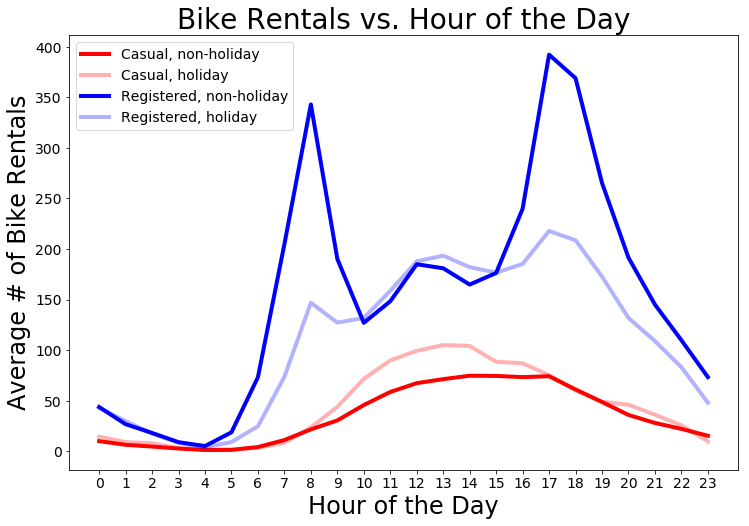

In [14]:
avg_casual_hol0 = [0] * 24
avg_casual_hol1 = [0] * 24
avg_registered_hol0 = [0] * 24
avg_registered_hol1 = [0] * 24
for h in range(0,24):
    avg_casual_hol0[h] = np.mean(bikes_df.query('holiday==0 and hour=={}'.format(h))['casual'])
    avg_casual_hol1[h] = np.mean(bikes_df.query('holiday==1 and hour=={}'.format(h))['casual'])
    avg_registered_hol0[h] = np.mean(bikes_df.query('holiday==0 and hour=={}'.format(h))['registered'])
    avg_registered_hol1[h] = np.mean(bikes_df.query('holiday==1 and hour=={}'.format(h))['registered'])

fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.plot(avg_casual_hol0, color='r', linewidth=4.0, label='Casual, non-holiday')
ax.plot(avg_casual_hol1, color='r', linewidth=4.0, alpha = 0.3, label='Casual, holiday')
ax.plot(avg_registered_hol0, color='b', linewidth=4.0, label='Registered, non-holiday')
ax.plot(avg_registered_hol1, color='b', linewidth=4.0, alpha = 0.3, label='Registered, holiday')

ax.set_ylabel('Average # of Bike Rentals',fontsize=24)
ax.set_title('Bike Rentals vs. Hour of the Day', fontsize=28)
ax.set_xlabel('Hour of the Day', fontsize=24)
ax.set_xticks(np.arange(0, 24, step=1))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(prop={'size':14})
plt.show()

<HR>
On holidays, the average number of **casual** riders increases during the workday (9am to 5pm), but remains about equal at every other time, relative to non-holidays. Oppositely, on holidays, the average number of **registered** riders drastically decreases during most of the day. Instead of peaking at the beginning and the end of the workday, this line generally increases until 5pm, when it begins to taper.<BR>
<HR>

#### 1.6  Use visualization to show how weather affects casual and registered rentals. What do you observe?

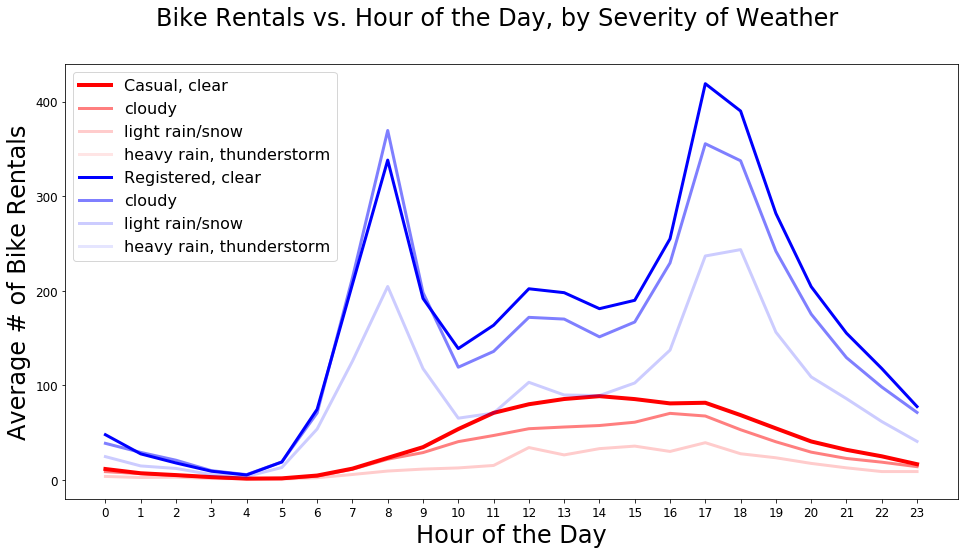

In [15]:
# your code here
avg_casual_w1 = [0] * 24
avg_casual_w2 = [0] * 24
avg_casual_w3 = [0] * 24
avg_casual_w4 = [0] * 24
avg_registered_w1 = [0] * 24
avg_registered_w2 = [0] * 24
avg_registered_w3 = [0] * 24
avg_registered_w4 = [0] * 24
for h in range(0,24):
    avg_casual_w1[h] = np.mean(bikes_df.query('weather==1 and hour=={}'.format(h))['casual'])
    avg_casual_w2[h] = np.mean(bikes_df.query('weather==2 and hour=={}'.format(h))['casual'])
    avg_casual_w3[h] = np.mean(bikes_df.query('weather==3 and hour=={}'.format(h))['casual'])
    avg_casual_w4[h] = np.mean(bikes_df.query('weather==4 and hour=={}'.format(h))['casual'])
    avg_registered_w1[h] = np.mean(bikes_df.query('weather==1 and hour=={}'.format(h))['registered'])
    avg_registered_w2[h] = np.mean(bikes_df.query('weather==2 and hour=={}'.format(h))['registered'])
    avg_registered_w3[h] = np.mean(bikes_df.query('weather==3 and hour=={}'.format(h))['registered'])
    avg_registered_w4[h] = np.mean(bikes_df.query('weather==4 and hour=={}'.format(h))['registered'])

fig, ax = plt.subplots(1,1, figsize=(16,8))

ax.plot(avg_casual_w1, color='r', label='Casual, clear', linewidth=4.0)
ax.plot(avg_casual_w2, color='r', alpha=0.5, label='cloudy', linewidth=3.0)
ax.plot(avg_casual_w3, color='r', alpha=0.2, label='light rain/snow', linewidth=3.0)
ax.plot(avg_casual_w4, color='r', alpha=0.1, label='heavy rain, thunderstorm', linewidth=3.0)
ax.plot(avg_registered_w1, color='b', label='Registered, clear', linewidth=3.0)
ax.plot(avg_registered_w2, color='b', alpha=0.5, label='cloudy', linewidth=3.0)
ax.plot(avg_registered_w3, color='b', alpha=0.2, label='light rain/snow', linewidth=3.0)
ax.plot(avg_registered_w4, color='b', alpha=0.1, label='heavy rain, thunderstorm', linewidth=3.0)

ax.set_ylabel('Average # of Bike Rentals',fontsize=24)
fig.suptitle('Bike Rentals vs. Hour of the Day, by Severity of Weather', fontsize=24)

ax.set_xlabel('Hour of the Day', fontsize=24)
ax.set_xticks(np.arange(0, 24, step=1))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(prop={'size':16})
plt.show()

<HR>
In general, as the weather gets more severe, less people rent bikes. However, the shape of the distributions remains similar no matter the weather, so regardless of the weather there are still more registered riders at the beginning and end of work days, and more casual riders in the afternoon.
    
One other thing to note is that there weren't enough instances of bike rentals in heavy rain or thunderstorms to create a separate line plot for them. In fact, there were only 3 rows with that kind of weather, making up less than 0.02% of the dataset.
<HR>

In [16]:
print("Rows with severe weather:", np.sum(bikes_df.weather == 4))
print("Proportion of dataset:", round(np.mean(bikes_df.weather == 4), 4))

Rows with severe weather: 3
Proportion of dataset: 0.0002


<div class='exercise'> <b> Question 2: Explore Seasonality on Bike Ridership. </b></div>
#### Seasonality and weather

Now let's examine the effect of weather and time of the year. For example, you want to see how ridership varies with season of the year. 

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being **ONE** day:

- `dteday`, the timestamp for that day (fine to set to noon or any other time)
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals

Name this dataframe `bikes_by_day` and use it for all of Question 2.

**2.2** How does **season** affect the number of bike rentals for **casual riders** or **registered riders** per day? Use the variable `season` for this question. Comment on your observations. 

**2.3** What percentage of rentals are made by casual riders or registered riders for each day of the week? Comment on any patterns you see and give a possible explanation.

**2.4** How is the **distribution of total number of bike rentals** different for sunny days vs cloudy days?

**2.5** Visualize how the **total number of rides** per day varies with the **season**. Do you see any **outliers**? (We define an outlier as a value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. This is the same rule used by pyplot's boxplot function). If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or an important event.

#### HINT
- Use .copy() when creating the new dataframe, so you leave the original untouched. We will come back to it later.
- Use .groupby() to creat the new dataframe. You will have to make some choice on how to aggregate the variables.

### Answers

#### 2.1 Make a new dataframe with the following subset ...

In [17]:
# your code here
bikes_by_day = bikes_df.groupby('dteday').agg({
    'weekday': np.mean,
    'weather': np.max,
    'season': np.mean,
    'month': np.mean,
    'temp': np.mean,
    'atemp': np.mean,
    'windspeed': np.mean,
    'hum': np.mean,
    'casual': np.sum,
    'registered': np.sum,
    'counts': np.mean})
bikes_by_day.head()
#np.mean(bikes_by_day.query('season==1'))

,weekday,weather,season,month,temp,atemp,windspeed,hum,casual,registered,counts
dteday,,,,,,,,,,,
2011-01-01,6,3,1,1,0.344167,0.363625,0.160446,0.805833,331,654,985
2011-01-02,0,3,1,1,0.363478,0.353739,0.248539,0.696087,131,670,801
2011-01-03,1,1,1,1,0.196364,0.189405,0.248309,0.437273,120,1229,1349
2011-01-04,2,2,1,1,0.200000,0.212122,0.160296,0.590435,108,1454,1562
2011-01-05,3,1,1,1,0.226957,0.229270,0.186900,0.436957,82,1518,1600


#### 2.2 How does season affect the number of bike ...

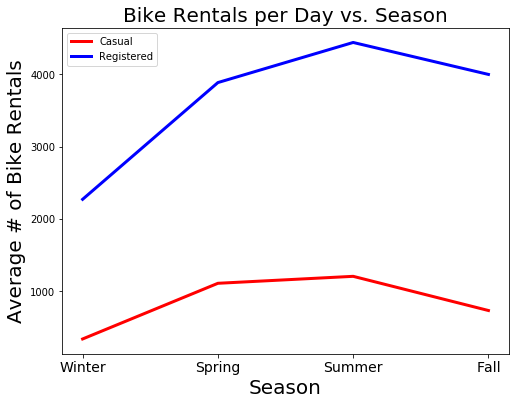

In [18]:
# your code here
fig, ax = plt.subplots(1,1, figsize=(8,6))

casual_per_day = [np.mean(bikes_by_day.query('season=={}'.format(i))['casual']) for i in range(1,5)]
registered_per_day = [np.mean(bikes_by_day.query('season=={}'.format(i))['registered']) for i in range(1,5)]

ax.plot(casual_per_day, color='r', linewidth=3.0, label='Casual')
ax.plot(registered_per_day, color='b', linewidth=3.0, label='Registered')
ax.set_xlabel('Season', fontsize=20)
ax.set_xticks(np.arange(0, 4, step=1))
ax.set_xticklabels(['Winter', 'Spring', 'Summer', 'Fall'], fontsize=14)
ax.set_ylabel('Average # of Bike Rentals', fontsize=20)
ax.set_title('Bike Rentals per Day vs. Season', fontsize=20)
ax.legend();

<HR>
Unsurprisingly, for both casual and registered riders, bike rentals peak during the summer and reach a low point during the winter. Rentals in the spring and fall land in between.
<HR>

#### 2.3 What percentage of rentals are made by casual riders or registered riders ...

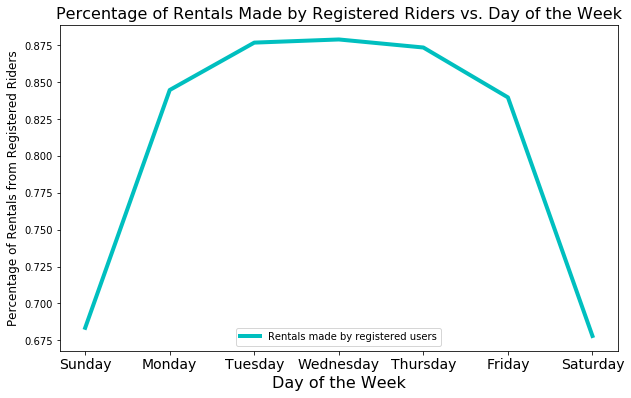

In [19]:
# create list of percentage of registered users for every day of the week
per_registered = [0] * 7

# for each day of the week
for i in range(0,7):
    
    # query for each day of the week
    bikes_query = bikes_by_day.query('weekday=={}'.format(i))
    
    # percent registered = sum of registered riders / sum of total riders
    per_registered[i] = np.sum(bikes_query['registered']) / np.sum(bikes_query['counts'])

# create plot
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(per_registered, color='c', linewidth=4.0, label='Rentals made by registered users')
ax.set_title('Percentage of Rentals Made by Registered Riders vs. Day of the Week', fontsize=16)
ax.set_xlabel('Day of the Week', fontsize=16)
ax.set_ylabel('Percentage of Rentals from Registered Riders', fontsize=12)
ax.set_xticklabels(['', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], fontsize=14)
ax.legend()

plt.show()

<HR>
It is clear that the percentage of registered riders over the weekend is significantly lower than that of registered riders on weekdays. It could be that many registered users are people who bike to work Monday to Friday, and so these people have no need to rent bikes on the weekends.
<HR>

#### 2.4 How is the distribution of total number of bike rentals different ...

count     151.000000
mean     5002.185430
std      2026.020755
min       431.000000
25%      3755.500000
50%      4916.000000
75%      6868.000000
max      8395.000000
Name: counts, dtype: float64
count     580.000000
mean     4374.739655
std      1893.837927
min        22.000000
25%      3003.500000
50%      4400.500000
75%      5740.750000
max      8714.000000
Name: counts, dtype: float64


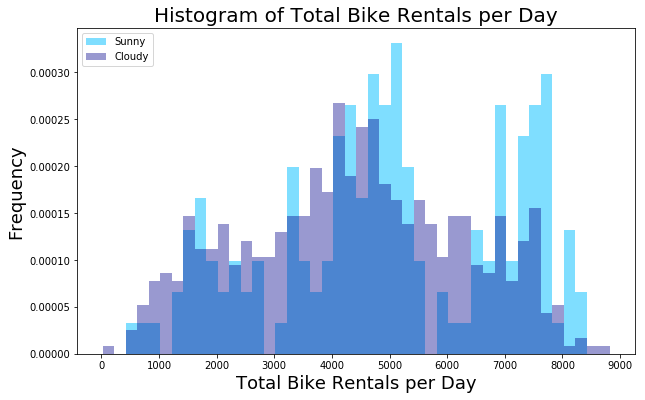

In [20]:
# your code here
sunny_data = bikes_by_day.query('weather==1')['counts']
cloudy_data = bikes_by_day.query('weather!=1')['counts']

fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.hist(sunny_data, bins=range(min(cloudy_data), max(cloudy_data)+200, 200),
        density=True,
        color='#00BFFF',
        alpha=0.5,
        edgecolor='none',
        linewidth=1.2,
        label='Sunny')

ax.hist(cloudy_data, bins=range(min(cloudy_data), max(cloudy_data)+200, 200),
        density=True,
        color='#00008B',
        alpha=0.4,
        edgecolor='none',
        linewidth=1.2,
        label='Cloudy')

ax.set_xlabel('Total Bike Rentals per Day', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_title('Histogram of Total Bike Rentals per Day', fontsize=20)
ax.set_xticks(np.arange(0, 10000, step=1000))
ax.legend(loc='upper left')

print(sunny_data.describe())
print(cloudy_data.describe())

<HR>
On average, about 625 more bikes are rented on sunny days than on cloudy days. On sunny days, the histogram shows two major peaks at about 5,000 and 7,500 total bikes rented per day, whereas rentals on cloudy days more closely resemble a normal distribution centered at 4,400 rentals per day. Bike rentals on sunny days also have greater variance than rentals on cloudy days do.
<HR>

#### 2.5 Visualize how the total number of rides per day ...

2012-03-17 00:00:00
2012-10-29 00:00:00


,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,day,counts
15881,2012-10-28,4,22,0,0,0,3,0.44,0.4394,0.88,0.3582,2,35,1,10,28,4459
15882,2012-10-28,4,23,0,0,0,3,0.42,0.4242,0.94,0.3582,2,12,1,10,28,4459
15883,2012-10-29,4,0,0,1,1,3,0.44,0.4394,0.88,0.3582,2,20,1,10,29,22
15884,2012-10-30,4,13,0,2,1,3,0.30,0.2727,0.81,0.3582,11,105,1,10,30,1096
15885,2012-10-30,4,14,0,2,1,3,0.30,0.2727,0.81,0.3582,8,118,1,10,30,1096


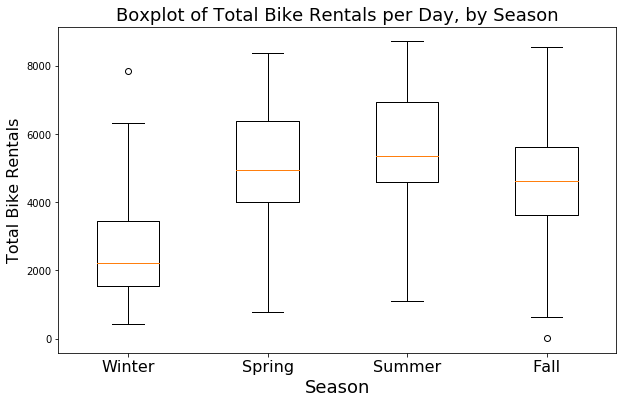

In [21]:
# your code here

fig, ax = plt.subplots(1,1, figsize=(10,6))

season_counts = [bikes_by_day.query('season==1')['counts'],
              bikes_by_day.query('season==2')['counts'],
              bikes_by_day.query('season==3')['counts'],
              bikes_by_day.query('season==4')['counts']]
    
ax.boxplot(season_counts)
ax.set_xlabel('Season', fontsize=18)
ax.set_xticklabels(['Winter', 'Spring', 'Summer', 'Fall'], fontsize=16)
ax.set_ylabel('Total Bike Rentals', fontsize=16)
ax.set_title('Boxplot of Total Bike Rentals per Day, by Season', fontsize=18)

print(season_counts[0].index[np.argmax(season_counts[0].values)])
print(season_counts[3].index[np.argmin(season_counts[3].values)])
bikes_df.query('counts==22')
bikes_df.iloc[15881:15886]

<HR>
There are only two outliers in this data: one on March 17th, and one on October 29th. The outlier on March 17th is much higher than all other values in the winter, most likely because of St. Patrick's Day. On the other hand, the outlier on October 29th appears to have been caused by an error in data collection. Data was only collected in the first hour of the day, and so the outlier only represents the number of rentals between 12am and 1am.
<HR>

<div class='exercise'> <b> Question 3: Prepare the data for Regression </b> </div>

**3.1** Visualize and describe inter-dependencies among the following variables: `weekday`, `season`, `month`,`weather`, `temp`, `atemp`, `hum`, `windspeed`, `casual`,`registered`, `counts`. Note and comment on any strongly related variables.

**3.2** Convert the categorical attributes into multiple binary attributes using **one-hot encoding**. 


**3.3** Split the initial `bikes_df` dataset (with hourly data about rentals) into train and test sets. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm. We ask you to create your train and test sets, but for consistency and easy checking we ask that, for the rest of this problem set, you use the train and test set provided in the question below.

**3.4** Read `data/BSS_train.csv` and `data/BSS_test.csv` into dataframes `BSS_train` and `BSS_test`, respectively. After checking your train and test datasets for accuracy, remove the `dteday` column from both train and test dataset. We do not need it, and its format cannot be used for analysis. Also, remove any predictors that would make predicting the `count` trivial.

**3.5** Calculate the **Pearson correlation** coefficients between all the features. Visualize the matrix using a heatmap. Which predictors have a positive correlation with the number of bike rentals? For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Identify pairs of predictors with collinearity >0.7.

#### Hints: 
- You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.



#### Answers

#### 3.1 Visualize and describe inter-dependencies  ... 

In [22]:
bikes_by_day.head()

,weekday,weather,season,month,temp,atemp,windspeed,hum,casual,registered,counts
dteday,,,,,,,,,,,
2011-01-01,6,3,1,1,0.344167,0.363625,0.160446,0.805833,331,654,985
2011-01-02,0,3,1,1,0.363478,0.353739,0.248539,0.696087,131,670,801
2011-01-03,1,1,1,1,0.196364,0.189405,0.248309,0.437273,120,1229,1349
2011-01-04,2,2,1,1,0.200000,0.212122,0.160296,0.590435,108,1454,1562
2011-01-05,3,1,1,1,0.226957,0.229270,0.186900,0.436957,82,1518,1600


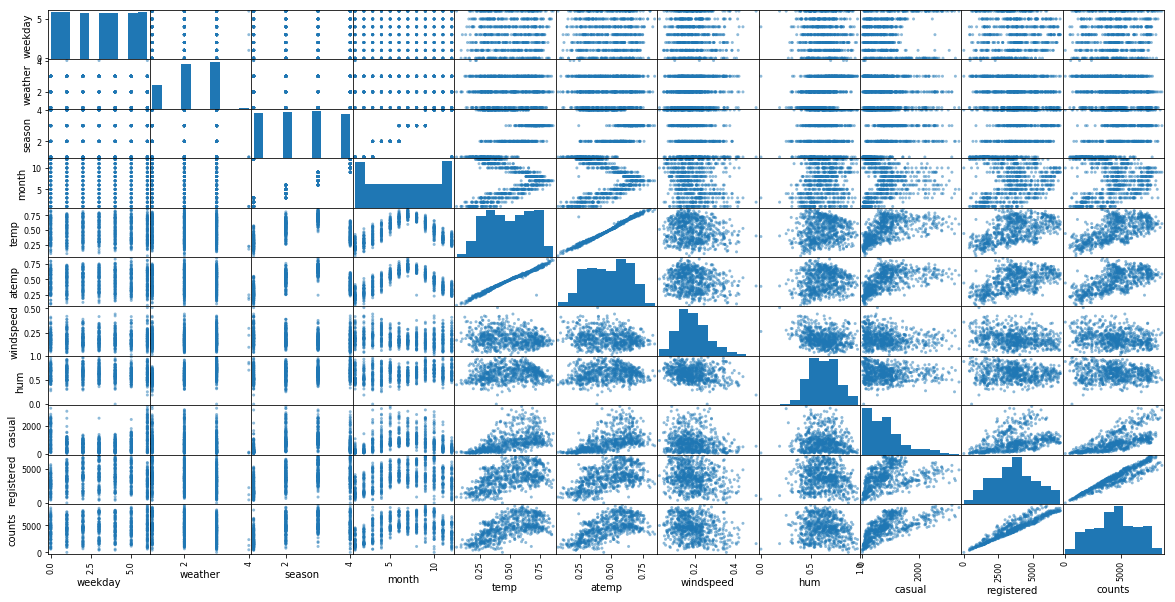

In [23]:
# Create Scatter Matrix
scatter_matrix(bikes_by_day, figsize=(20,10));
plt.show()

<HR>
Some strong interdependencies from the data immediately jump out: `temp` and `atemp` are basically a straight line, and `month` and `season` are obviously also directly related. `registered` and `casual` both have a strong relationship with `counts` (which is comprised fo their sum), although the relationship between `registered` and `counts` is much stronger and more apparent. There are other apparent sinusoidal relationships between `month` and the following variables: `temp`; `atemp`; `counts`; `registered`; `casual`.  
    <HR>

#### 3.2 Convert the categorical attributes  ....

In [24]:
# Add dummy variables
bikes_dummy = pd.get_dummies(bikes_by_day, columns = ['season','month','weekday','weather'])

# Drop Unnecessary Columns
bikes_dummy = bikes_dummy.drop(columns=['season_1', 'month_1', 'weekday_0', 'weather_1'])

# Rename seasons and weekdays intuitively
bikes_dummy = bikes_dummy.rename(columns = 
                                 {'season_2':'spring','season_3':'summer','season_4':'fall',
                                 'weekday_1':'Monday', 'weekday_2':'Tuesday',
                                 'weekday_3':'Wednesday', 'weekday_4':'Thursday',
                                 'weekday_5':'Friday', 'weekday_6':'Saturday'})

# View Data
bikes_dummy.head()

,temp,atemp,windspeed,hum,casual,registered,counts,spring,summer,fall,...,month_12,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,weather_2,weather_3,weather_4
dteday,,,,,,,,,,,,,,,,,,,,,
2011-01-01,0.344167,0.363625,0.160446,0.805833,331,654,985,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2011-01-02,0.363478,0.353739,0.248539,0.696087,131,670,801,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2011-01-03,0.196364,0.189405,0.248309,0.437273,120,1229,1349,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2011-01-04,0.200000,0.212122,0.160296,0.590435,108,1454,1562,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2011-01-05,0.226957,0.229270,0.186900,0.436957,82,1518,1600,0,0,0,...,0,0,0,1,0,0,0,0,0,0


#### 3.3 Split the initial bikes_df dataset...

In [25]:
# Split train/test, stratifying by month
train_data, test_data = train_test_split(bikes_df, test_size = 0.2, stratify=bikes_df['month'])

sklearn's train_test_split function is able to split datasets into stratified train and tests sets fairly easily. By selecting the `month` column as the one to stratify by, we are telling the algorithm that we want the proportion of each value of `month` to be equal in the training and test sets, so essentially the algorithm finds all the rows with `month` = 1 and assigns 80% of those to the training set and 20% of those to the test set, then it repeats that process for every `month` value. Below we check to make sure that the training and test sets indeed have equal proportions of every month and find that the train_test_split function worked just fine.

In [26]:
# Check stratification
for month in range(1, 13):
    print("Month {}: Train Prop: {}, Test Prop: {}".format(month, 
                                round(np.mean(train_data.month == month),3), 
                                round(np.mean(test_data.month == month),3)))

Month 1: Train Prop: 0.082, Test Prop: 0.082
Month 2: Train Prop: 0.077, Test Prop: 0.077
Month 3: Train Prop: 0.085, Test Prop: 0.085
Month 4: Train Prop: 0.083, Test Prop: 0.083
Month 5: Train Prop: 0.086, Test Prop: 0.086
Month 6: Train Prop: 0.083, Test Prop: 0.083
Month 7: Train Prop: 0.086, Test Prop: 0.086
Month 8: Train Prop: 0.085, Test Prop: 0.085
Month 9: Train Prop: 0.083, Test Prop: 0.083
Month 10: Train Prop: 0.084, Test Prop: 0.083
Month 11: Train Prop: 0.083, Test Prop: 0.083
Month 12: Train Prop: 0.085, Test Prop: 0.085


#### 3.4  Read `data/BSS_train.csv` and `data/BSS_test.csv` into ...

In [27]:
# Read Data
BSS_train = pd.read_csv("data/BSS_train.csv")
BSS_test = pd.read_csv("data/BSS_test.csv")

In [28]:
# View Train Data
BSS_train.head()

,Unnamed: 0,dteday,hour,holiday,year,workingday,temp,atemp,hum,windspeed,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,0,2011-01-01,0,0,0,0,0.24,0.2879,0.81,0.0,...,0,0,0,0,0,0,1,0,0,0
1,1,2011-01-01,1,0,0,0,0.22,0.2727,0.80,0.0,...,0,0,0,0,0,0,1,0,0,0
2,2,2011-01-01,2,0,0,0,0.22,0.2727,0.80,0.0,...,0,0,0,0,0,0,1,0,0,0
3,3,2011-01-01,3,0,0,0,0.24,0.2879,0.75,0.0,...,0,0,0,0,0,0,1,0,0,0
4,4,2011-01-01,4,0,0,0,0.24,0.2879,0.75,0.0,...,0,0,0,0,0,0,1,0,0,0


In [29]:
# View Test Data
BSS_test.head()

,Unnamed: 0,dteday,hour,holiday,year,workingday,temp,atemp,hum,windspeed,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,6,2011-01-01,6,0,0,0,0.22,0.2727,0.80,0.0000,...,0,0,0,0,0,0,1,0,0,0
1,9,2011-01-01,9,0,0,0,0.32,0.3485,0.76,0.0000,...,0,0,0,0,0,0,1,0,0,0
2,20,2011-01-01,20,0,0,0,0.40,0.4091,0.87,0.2537,...,0,0,0,0,0,0,1,1,0,0
3,33,2011-01-02,10,0,0,0,0.36,0.3485,0.81,0.2239,...,0,0,0,0,0,0,0,1,0,0
4,35,2011-01-02,12,0,0,0,0.36,0.3333,0.66,0.2985,...,0,0,0,0,0,0,0,1,0,0


In [30]:
# Drop unnecessary columns
BSS_train = BSS_train.drop(columns=['dteday', 'Unnamed: 0'])
BSS_test = BSS_test.drop(columns=['dteday', 'Unnamed: 0'])

In [31]:
# Drop columns with predictors that would make
# calculating 'counts' trivial
BSS_train = BSS_train.drop(columns=['casual', 'registered'])
BSS_test = BSS_test.drop(columns=['casual', 'registered'])

<HR>
Since `counts` is defined as `casual` + `registered`, we removed both of those predictors, as they would have made the "prediction" of `counts` trivial.
<HR>

#### 3.5 Pearson Correlation

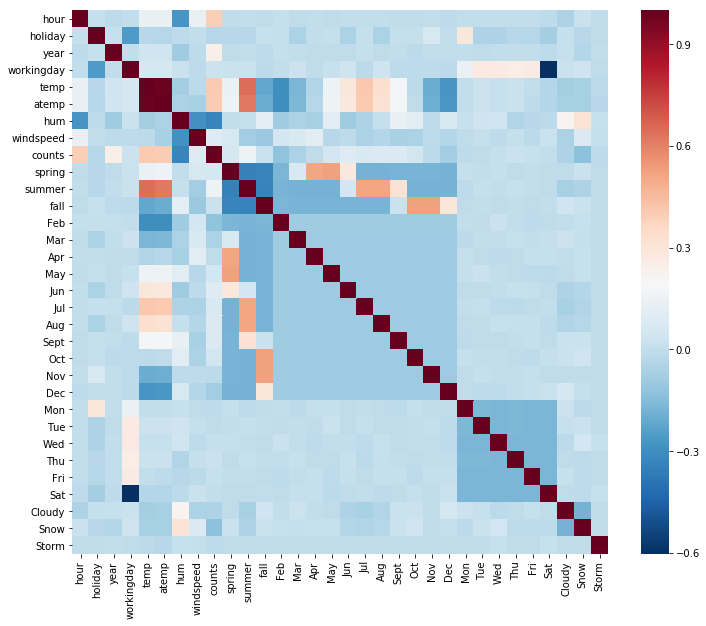

In [32]:
# Correlation Matrix

# Declare Plot
plt.figure(figsize = (12,10))

# Calculate Matrix
corr_matrix = np.corrcoef(BSS_train.T)

# Create Heatmap
sns.heatmap(corr_matrix, cmap="RdBu_r", 
            xticklabels=BSS_train.columns.values,
            yticklabels=BSS_train.columns.values);

<HR>
Color scheme shows redder values have higher correlation; central diagonal of dark red squares shows that each variable is perfectly correlated with itself. The larger square in the top left corner shows the almost perfect correlation between `temp` and `atemp`. Heatmap also shows high correlation between `temp` and `summer`, as well as months and seasons.

For `counts`, the highest correlations seem to be `hour` and `temp`/`atemp`.
<HR>

In [33]:
# Identify correlations above 0.7s
for row in range(len(corr_matrix)):
    for col in range(row):
        if corr_matrix[row][col] > 0.7:
            print("Predictors #{} and #{} have a correlation greater than 0.7."
                  .format(row, col))

Predictors #5 and #4 have a correlation greater than 0.7.


This predictor pair represents `temp` and `atemp`, as was visible in the heatmap.

<div class='exercise'> <b> Question 4: Multiple Linear Regression </b> </div>

**4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms), and report its $R^2$ score on the train and test sets.


**4.2** Find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value < 0.05). Comment on the results.


**4.3** Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is slightly different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms? 

### Answers
#### 4.1 Use statsmodels to fit a ... 


In [34]:
# Build train predictor dataframe
predictors_train = BSS_train.drop(columns=['counts'])
predictors_train = sm.add_constant(predictors_train)
predictors_train.head()

,const,hour,holiday,year,workingday,temp,atemp,hum,windspeed,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,1.0,0,0,0,0,0.24,0.2879,0.81,0.0,0,...,0,0,0,0,0,0,1,0,0,0
1,1.0,1,0,0,0,0.22,0.2727,0.80,0.0,0,...,0,0,0,0,0,0,1,0,0,0
2,1.0,2,0,0,0,0.22,0.2727,0.80,0.0,0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,3,0,0,0,0.24,0.2879,0.75,0.0,0,...,0,0,0,0,0,0,1,0,0,0
4,1.0,4,0,0,0,0.24,0.2879,0.75,0.0,0,...,0,0,0,0,0,0,1,0,0,0


In [35]:
# Build response variable array
counts_train = BSS_train.counts

# Fit StatsModel
fit_sm = sm.OLS(counts_train, predictors_train).fit()

In [36]:
# Get Training R Squared
train_r2 = fit_sm.rsquared
print('R Squared for the training model:', round(train_r2, 4))

R Squared for the training model: 0.4065


In [37]:
# Build test predictor dataframe
predictors_test = BSS_test.drop(columns=['counts'])
predictors_test = sm.add_constant(predictors_test)

# Check that it's equal to train predictor dataframe
np.array_equal(predictors_train.columns.values, predictors_test.columns.values)

True

In [38]:
# Get Test R Squared

# Get actual values
counts_test = BSS_test.counts

# Get predicted values
test_predict = fit_sm.predict(predictors_test)

# Calculate R Squared
test_r2 = r2_score(counts_test, test_predict)
print('R Squared for the test set:', round(test_r2, 4))

R Squared for the test set: 0.4064


#### 4.2 Find out which of estimated coefficients ...

In [39]:
# Find Significant Predictors
fit_sm.pvalues <.05

const          True
hour           True
holiday        True
year           True
workingday     True
temp           True
atemp         False
hum            True
windspeed      True
spring         True
summer         True
fall           True
Feb           False
Mar           False
Apr            True
May            True
Jun            True
Jul            True
Aug            True
Sept          False
Oct           False
Nov            True
Dec           False
Mon           False
Tue           False
Wed           False
Thu           False
Fri           False
Sat            True
Cloudy         True
Snow           True
Storm         False
dtype: bool

The majority of predictors seem to be significant. The predictors we have already found to have a relationship with ride counts (from visual inspection) are significant: `hour`, `holiday`, `workingday`, the seasons, and the weather.
Interestingly, only `temp` and not `atemp` was significant, probably because they are so collinear that all the information contained in `atemp` was already available to the model through `temp`.
It's hard to look too much into the significance of the predictors when so many of them are so deeply intertwined, like `workingday` is with the actual days of the week, or `summer` is with `Jun`, `Jul`, `August`, and `Sept`.

#### 4.3 Make a plot of residuals of the fitted ...

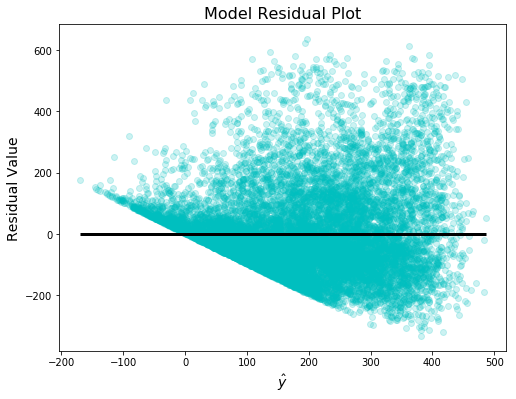

In [40]:
# Residual Plot

# Calculate Y hat and residuals
residuals = counts_train - fit_sm.fittedvalues

# Plot Residuals
plt.figure(figsize = (8,6))
plt.scatter(fit_sm.fittedvalues, residuals, color='c', alpha=.2)

# Add Horizontal line
plt.hlines(0, min(fit_sm.fittedvalues), max(fit_sm.fittedvalues), colors='k', lw=3)

# Label
plt.title('Model Residual Plot', fontsize=16)
plt.xlabel('$\hat{y}$', fontsize=14)
plt.ylabel('Residual Value', fontsize=14)

plt.show()

This plot immediately shows that the errors are not normally distributed, and that their variance is not uniform, which suggests that the relationship between predictors and response variable might not be linear after all (which would also explain why we don't have a very high $R^2$ value even with a lot of predictors).

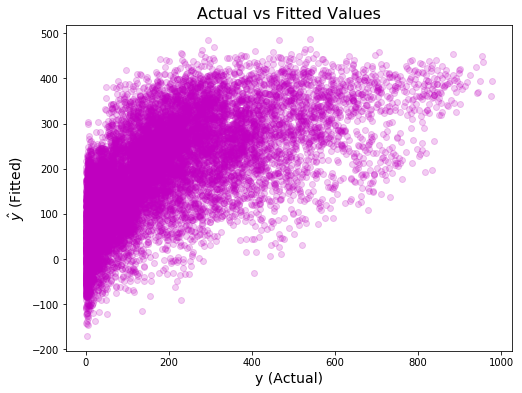

In [41]:
# Actual vs Fitted Values Plot
plt.figure(figsize = (8,6))
plt.scatter(counts_train, fit_sm.fittedvalues, color='m', alpha=.2)

# Label
plt.title('Actual vs Fitted Values', fontsize=16)
plt.xlabel('y (Actual)', fontsize=14)
plt.ylabel('$\hat{y}$ (Fitted)', fontsize=14)
plt.show()

Plotting the actual values against the fitted values offers an insight into where we could have gone wrong: actual `counts` cannot be negative, but fitted counts _can_ be negative, which means we might need to alter our approach to fitting the model. For example, if we tried to model exp(`counts`), then negative predictions wouldn't be conceptually wrong, for example. We could also alter our approach to making predictions, instead of to fitting the model, and just cap predictions so that any negative prediction is turned to a prediction of zero.

In [42]:
# Show model summary for good measure
fit_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     316.8
Date:                Mon, 16 Jul 2018   Prob (F-statistic):               0.00
Time:                        17:44:38   Log-Likelihood:                -88306.
No. Observations:               13903   AIC:                         1.767e+05
Df Residuals:                   13872   BIC:                         1.769e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.0830      8.641     -2.440      0.015     -38.020      -4.146
hour           7.2214      0.184     39.144      0.000       6.860       7.583
holiday      -18.0958      6.597     -2.743      0.006     -31.027      -5.165
year          76.3519      2.380     32.084      0.000      71.687      81.017
workingday    11.3178      2.751      4.114      0.000       5.926      16.710
temp         333.2482     44.162      7.546      0.000     246.684     419.812
atemp         74.6312     46.207      1.615      0.106     -15.940     165.202
hum         -205.4959      7.801    -26.343      0.000    -220.786    -190.205
windspeed     22.5168     10.753      2.094      0.036       1.439      43.595
spring        43.1541      7.417      5.818      0.000      28.615      57.693
summer        29.5426      8.773      3.367      0.001      12.346      46.739
fall          68.5953      7.492      9.156      0.000      53.911      83.280
Feb           -7.6430      5.966     -1.281      0.200     -19.336       4.050
Mar          -11.6737      6.665     -1.752      0.080     -24.737       1.390
Apr          -41.5244      9.878     -4.204      0.000     -60.886     -22.163
May          -33.2927     10.543     -3.158      0.002     -53.958     -12.628
Jun          -65.8039     10.716     -6.141      0.000     -86.809     -44.799
Jul          -93.4805     12.086     -7.734      0.000    -117.171     -69.789
Aug          -59.2081     11.832     -5.004      0.000     -82.401     -36.015
Sept         -16.0517     10.575     -1.518      0.129     -36.780       4.676
Oct          -16.1602      9.865     -1.638      0.101     -35.497       3.177
Nov          -25.8732      9.527     -2.716      0.007     -44.547      -7.199
Dec          -10.2043      7.614     -1.340      0.180     -25.128       4.719
Mon           -2.6601      2.978     -0.893      0.372      -8.498       3.177
Tue           -6.1425      3.208     -1.915      0.056     -12.430       0.145
Wed            2.2964      3.183      0.721      0.471      -3.943       8.536
Thu           -3.1611      3.185     -0.993      0.321      -9.404       3.082
Fri            2.8892      3.186      0.907      0.364      -3.355       9.133
Sat           14.9459      4.382      3.411      0.001       6.357      23.535
Cloudy         6.7868      2.900      2.341      0.019       1.103      12.470
Snow         -28.2859      4.819     -5.870      0.000     -37.731     -18.841
Storm         42.3569     98.377      0.431      0.667    -150.475     235.189
==============================================================================
Omnibus:                     2831.359   Durbin-Watson:                   0.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5657.789
Skew:                           1.224   Prob(JB):                         0.00
Ku

<div class='exercise'> <b>Question 5: Subset Selection </b> </div>

**5.1** Implement forward step-wise  selection to select a minimal subset of predictors that are related to the response variable: 

We require that you implement the method **from scratch**. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. 

**5.2** Do these methods eliminate one or more of the colinear predictors (if any) identified in Question 3.5?  If so, which ones. Briefly explain (3 or fewer sentences) why you think this may be the case.

**5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Question 4 using all predictors?

### Answers

#### 5.1  Implement forward step-wise ....

In [43]:
## Forward Selection Algorithm

# Adapted from https://planspace.org/20150423-forward_selection_with_statsmodels/

def forward_selection(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by BIC
           
    selected: list of predictors identified by algorithm
    """
    
    # Declare Initial Set of Predictors
    remaining = set(data.columns)
    remaining.remove(response)
    
    # Declare Array to store optimal variables
    selected = []
    step = 0
    
    # Declare initial values for BIC
    current_bic, best_new_bic = 10000000.0, 10000000.0
    
    # While there are still variables in the set
    # and our best BIC and current BIC are equal
    while remaining and current_bic == best_new_bic:
        
        # Declare array to store potential variables and BIC
        bics_with_predictors = []
        
        # For each predictor that hasn't been used
        for predictor in remaining:
            
            # Format formula for fitting
            formula = "{} ~ {}".format(response,
                                           ' + '.join(selected + [predictor]))
            
            # Fit model and calculate BIC
            bic = sm.formula.ols(formula, data).fit().bic
            
            # Append BIC and predictor tuple
            bics_with_predictors.append((bic, predictor))
        
        # Sort all BICs in descending order
        bics_with_predictors.sort(reverse=True)
        
        # Identify best (lowest) BIC and corresponding predictor
        best_new_bic, best_predictor = bics_with_predictors.pop()
        
        if best_new_bic < current_bic:
            
            # Remove corresponding predictor from predictor set
            remaining.remove(best_predictor)
            
            # Add corresponding predictor to selected set
            selected.append(best_predictor)
            
            # Print Steps and Additions
            print("Step {}: Added predictor '{}'".format(step, best_predictor))
            print("\tBest BIC: {}".format(round(best_new_bic, 3)))
            step += 1
            
            # Update BIC
            current_bic = best_new_bic
    
    # Format final formula
    formula = "{} ~ {}".format(response,
                                   ' + '.join(selected))
    
    # Print Final Update
    print("Step {}: No predictor lowered BIC.\n".format(step))
    print("Final predictors:\n", formula)
    
    # Fit BIC optimized model
    model = sm.formula.ols(formula, data).fit()
    
    return model, selected

In [44]:
# Fit BIC optimized model
optimized_model, optimized_predictors = forward_selection(data=BSS_train, response='counts')

Step 0: Added predictor 'temp'
	Best BIC: 181379.568
Step 1: Added predictor 'hour'
	Best BIC: 179312.319
Step 2: Added predictor 'year'
	Best BIC: 178221.28
Step 3: Added predictor 'hum'
	Best BIC: 177402.863
Step 4: Added predictor 'fall'
	Best BIC: 177021.753
Step 5: Added predictor 'Jul'
	Best BIC: 176899.733
Step 6: Added predictor 'Snow'
	Best BIC: 176868.324
Step 7: Added predictor 'Aug'
	Best BIC: 176843.139
Step 8: Added predictor 'Jun'
	Best BIC: 176802.821
Step 9: Added predictor 'holiday'
	Best BIC: 176791.365
Step 10: Added predictor 'spring'
	Best BIC: 176790.387
Step 11: No added predictor lowered BIC.

Final predictors:
 counts ~ temp + hour + year + hum + fall + Jul + Snow + Aug + Jun + holiday + spring


In [45]:
print("BIC of full predictor model: {}\nBIC of optimized model: {}\nImprovement: {}"
     .format(round(fit_sm.bic, 1), round(optimized_model.bic, 1), 
             round(fit_sm.bic - optimized_model.bic, 1)))

BIC of full predictor model: 176908.3
BIC of optimized model: 176790.4
Improvement: 117.9


#### 5.2 Do these methods eliminate ...

<HR>
Yes, this method eliminates the predictor `atemp` while keeping `temp`. In fact, we see that `temp` is the first predictor added by the algorithm, since it is highly correlated with `counts` (see heatmap in 3.5). However, because `temp` and `atemp` are almost perfectly correlated, adding the second would have been redundant and punished by the BIC, since it would mean adding an extra predictor that did not contribute any further predictive ability. 
<HR>

#### 5.3 In each case, fit linear regression  ...

In [46]:
# Get predicted test values
opt_test_predict = optimized_model.predict(predictors_test)

# Calculate R Squared
opt_test_r2 = r2_score(counts_test, opt_test_predict)

# Compare
print('Full Predictor Model R Squared for the test set:', round(test_r2, 4))
print('Optimized Model R Squared for the test set:', round(opt_test_r2, 4))

Full Predictor Model R Squared for the test set: 0.4064
Optimized Model R Squared for the test set: 0.4047


<HR>
The test $R^2$ values are essentially the same under both models, but the optimized one uses 11 predictors instead of 31, so we get the same level of predictive power at a much lower level of model complexity, which is still a good tradeoff.
While we were hoping that the optimized model would improve on the test $R^2$, upon discussion with Prof. Rader in office hours we conjectured that the variables our model selected carry almost the entirety of the predictive power available in the dataset, and that the extraneous varibles carry almost no predictive power on top of that, so the Optimized model is basically the same as the Full model but without filler variables.
<HR>

<div class='exercise'> <b> Question 6: Polynomial Regression </b> </div> 

We will now try to improve the performance of the regression model by including higher-order polynomial terms. 

**6.1** For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a polynomial regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in the previous question? Using a $t$-tests, find out which of the estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%. 

In [47]:
# build design matrix for degree 4 polynomial regression
def build_model4_design(df):
    
    # get continuous variables
    cont_predictors = df[['temp', 'atemp', 'hum', 'windspeed']].copy()

    # convert to numpy array
    design_mat = df.as_matrix()
    
    # degree 4 polynomials
    transformer_4 = PolynomialFeatures(4, include_bias=False)

    # for each continuous predictor
    for predictor in cont_predictors:   
        
        # append new polynomial predictors to the design matrix
        new_predictors = transformer_4.fit_transform(cont_predictors[predictor].values.reshape(-1, 1))[:,1:]
        design_mat = np.concatenate([design_mat, new_predictors], axis=1)

    # add the names of new predictors to list of columns   
    new_cols = []
    for i in range(len(cont_predictors.columns)):
        new_cols = new_cols + [cont_predictors.columns[i] + '2',
                               cont_predictors.columns[i] + '3',
                               cont_predictors.columns[i] + '4']
    cols = list(predictors_train.columns) + new_cols
    
    # recreate DataFrame with new predictors
    design_df = pd.DataFrame(data=design_mat,index=range(len(design_mat)),columns=cols)    
        
    return design_df

In [48]:
# Make design matrices
train_design = build_model4_design(predictors_train)
test_design = build_model4_design(predictors_test)

# Fit model on training data
fitted_model_4 = OLS(endog = counts_train, exog = train_design, hasconst=True).fit()

# print R^2 for test data
print("Test R-squared:", round(r2_score(counts_test, fitted_model_4.predict(test_design)), 4))

/Users/nathangoldberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Test R-squared: 0.4203


In [49]:
# Look at Model Summary
fitted_model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     241.2
Date:                Mon, 16 Jul 2018   Prob (F-statistic):               0.00
Time:                        17:44:58   Log-Likelihood:                -88119.
No. Observations:               13903   AIC:                         1.763e+05
Df Residuals:                   13860   BIC:                         1.766e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -170.9866     38.451     -4.447      0.000    -246.356     -95.617
hour           7.0982      0.183     38.815      0.000       6.740       7.457
holiday      -19.9687      6.527     -3.059      0.002     -32.763      -7.175
year          79.1663      2.383     33.217      0.000      74.495      83.838
workingday    11.5480      2.721      4.244      0.000       6.214      16.882
temp         -98.4860    500.457     -0.197      0.844   -1079.449     882.477
atemp        972.1010    562.472      1.728      0.084    -130.421    2074.623
hum          808.4325    233.754      3.458      0.001     350.243    1266.622
windspeed     -4.8944     71.765     -0.068      0.946    -145.564     135.776
spring        42.1280      7.348      5.733      0.000      27.724      56.532
summer        21.2722      8.703      2.444      0.015       4.213      38.331
fall          67.7929      7.434      9.120      0.000      53.222      82.364
Feb            6.6054      6.034      1.095      0.274      -5.222      18.433
Mar           12.1869      6.872      1.773      0.076      -1.283      25.657
Apr          -18.8035      9.975     -1.885      0.059     -38.356       0.749
May          -24.9693     10.567     -2.363      0.018     -45.681      -4.257
Jun          -69.8240     10.710     -6.519      0.000     -90.817     -48.831
Jul          -92.0230     12.059     -7.631      0.000    -115.660     -68.386
Aug          -64.1045     11.886     -5.393      0.000     -87.404     -40.805
Sept          -7.2505     10.710     -0.677      0.498     -28.243      13.742
Oct            8.3218     10.013      0.831      0.406     -11.305      27.948
Nov           -0.5760      9.667     -0.060      0.952     -19.525      18.373
Dec            9.2113      7.752      1.188      0.235      -5.984      24.407
Mon           -4.8463      2.945     -1.645      0.100     -10.619       0.927
Tue           -6.9005      3.172     -2.175      0.030     -13.118      -0.683
Wed            1.0496      3.148      0.333      0.739      -5.122       7.221
Thu           -2.2895      3.153     -0.726      0.468      -8.469       3.890
Fri            4.5660      3.159      1.445      0.148      -1.626      10.758
Sat           15.5005      4.330      3.580      0.000       7.013      23.988
Cloudy         7.2913      2.872      2.539      0.011       1.662      12.921
Snow         -24.9330      4.967     -5.019      0.000     -34.670     -15.196
Storm         31.0141     97.153      0.319      0.750    -159.419     221.447
temp2      -3464.1586   1723.151     -2.010      0.044   -6841.767     -86.551
temp3       8584.3969   2391.413      3.590      0.000    3896.904    1.33e+04
temp4      -5050.0400   1143.548     -4.416      0.000   -7291.548   -2808.532
atemp2      -373.5642   2015.394     -0.185      0.853   -4324.009    3576.881
at

In [50]:
# Identify significant predictors

u = fitted_model_4.pvalues <.05

print("Predictors with a p-value under 0.05:\n")
for pred in range(len(u)):
    if u[pred]:
        print(u.index[pred])

Predictors with a p-value under 0.05:

const
hour
holiday
year
workingday
hum
spring
summer
fall
May
Jun
Jul
Aug
Tue
Sat
Cloudy
Snow
temp2
temp3
temp4
hum2
hum3
hum4
windspeed2
windspeed3
windspeed4


#  Written Report to the Administrators
<br>

<div class='exercise'> <b> Question 7 </b> </div>

Write a short summary report, intended for the administrators of the company, to address two major points (can be written as two large paragraphs):

1. How to predict ridership well (which variables are important, when is ridership highest/lowest, etc.).

2. Suggestions on how to increase the system revenue (what additional services to provide, when to give discounts, etc.).
 
Include your report below. The report should not be longer than 300 words and should include a maximum of 3 figures. 

### Answers
#### 7
<HR>
Your report here
<HR>

